In [1]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb

In [2]:
adata = sc.read('../data/eb_hv.h5ad', backed='r')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [7]:
ckpt_path='../src/wandb/run-20231231_183411-jqlyv7v1/files/epoch=5-step=14400.ckpt'
model = AEDist.load_from_checkpoint(ckpt_path, dim=adata.obsm['X_pca'].shape[1], emb_dim=2, w=256)

Calculating PHATE...
  Running PHATE on 3000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.59 seconds.
    Calculating affinities...
    Calculated affinities in 0.57 seconds.
  Calculated graph and diffusion operator in 1.19 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.40 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.78 seconds.
  Calculated landmark operator in 5.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.44 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.41 seconds.
Calculated PHATE in 12.33 seconds.


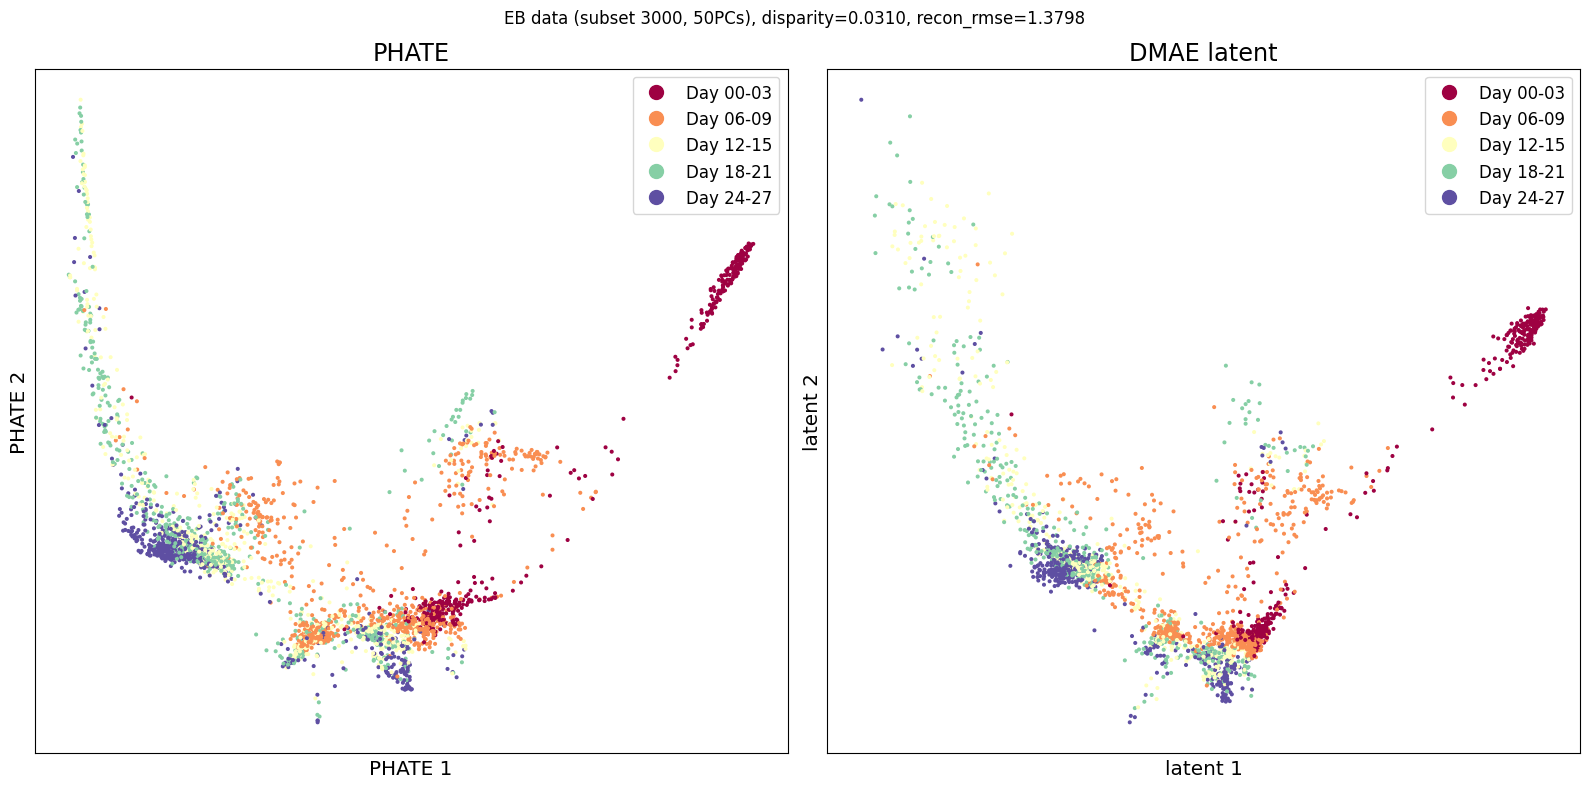

In [32]:
np.random.seed(42)
subset_id = np.random.choice(adata.shape[0], size=3000, replace=False)
X_pca_subset = adata.obsm['X_pca'][subset_id,:]
sample_label_subset = adata.obs['sample_labels'][subset_id]

phate_operator_s = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)
Y_phate_s = phate_operator_s.fit_transform(X_pca_subset)

phate_coordst = torch.tensor(Y_phate_s)
phate_D = torch.cdist(phate_coordst, phate_coordst).cpu().detach().numpy()

eval_loader = dataloader_from_pc(X_pca_subset, phate_D, batch_size=X_pca_subset.shape[0], shuffle=False)
sample_data = next(iter(eval_loader))

model.eval()
with torch.no_grad():
    xh, z = model(sample_data['x'])
    z = z.cpu().detach().numpy()
    xh = xh.cpu().detach().numpy()

recon_rmse = np.sqrt(np.square(xh - X_pca_subset).mean())

pc_rot, z_rot, disparity = procrustes(Y_phate_s, z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(Y_phate_s, c=sample_label_subset, ax=axes[0], cmap="Spectral",
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, c=sample_label_subset, ax=axes[1], cmap="Spectral",
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"EB data (subset 3000, 50PCs), disparity={disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()


Calculating PHATE...
  Running PHATE on 3000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.56 seconds.
    Calculating affinities...
    Calculated affinities in 0.59 seconds.
  Calculated graph and diffusion operator in 1.17 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.94 seconds.
  Calculated landmark operator in 4.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.37 seconds.
Calculated PHATE in 11.04 seconds.


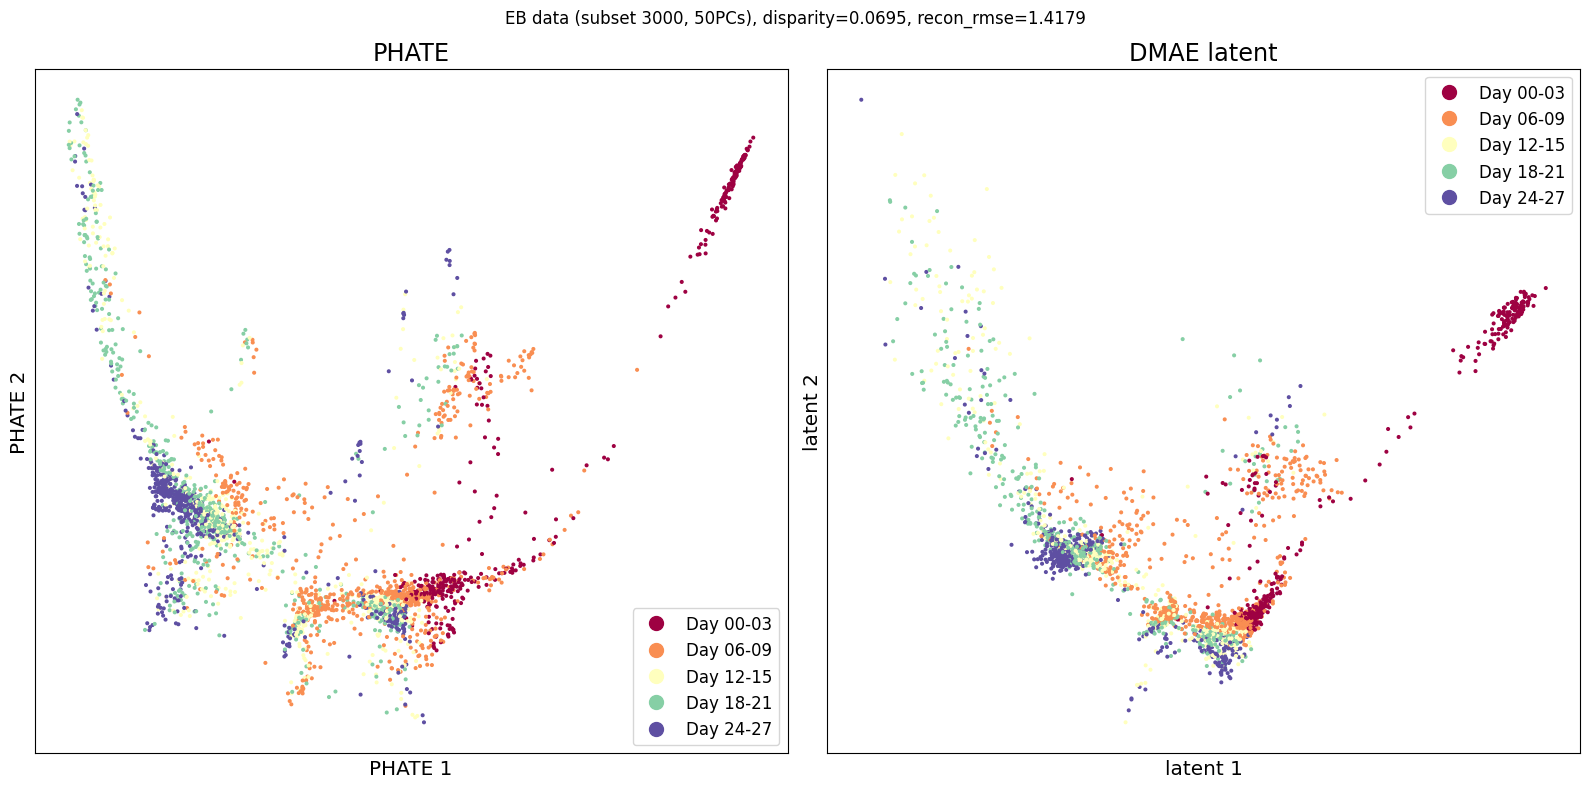

In [33]:
np.random.seed(43242)
subset_id = np.random.choice(adata.shape[0], size=3000, replace=False)
X_pca_subset = adata.obsm['X_pca'][subset_id,:]
sample_label_subset = adata.obs['sample_labels'][subset_id]

phate_operator_s = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)
Y_phate_s = phate_operator_s.fit_transform(X_pca_subset)

phate_coordst = torch.tensor(Y_phate_s)
phate_D = torch.cdist(phate_coordst, phate_coordst).cpu().detach().numpy()

eval_loader = dataloader_from_pc(X_pca_subset, phate_D, batch_size=X_pca_subset.shape[0], shuffle=False)
sample_data = next(iter(eval_loader))

model.eval()
with torch.no_grad():
    xh, z = model(sample_data['x'])
    z = z.cpu().detach().numpy()
    xh = xh.cpu().detach().numpy()

recon_rmse = np.sqrt(np.square(xh - X_pca_subset).mean())

pc_rot, z_rot, disparity = procrustes(Y_phate_s, z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(Y_phate_s, c=sample_label_subset, ax=axes[0], cmap="Spectral",
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, c=sample_label_subset, ax=axes[1], cmap="Spectral",
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"EB data (subset 3000, 50PCs), disparity={disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()
